# Outliers
So we should first divide our data set into train and tests, and remove outliers in the train set, but keep those in the test set, and measure how well our model is doing.

**Outlier detection:** The training data contains outliers which are defined as observations that are far from the others. Outlier detection estimators thus try to fit the regions where the training data is the most concentrated, ignoring the deviant observations.

**Novelty detection:** The training data is not polluted by outliers and we are interested in detecting whether a new observation is an outlier. In this context an outlier is also called a novelty.

## Outlier detection methods
<img src = "_images/08outliers_out1.png">

- **Z-score** For normal distribution
- **Interquartile Range** for skewed distribution
- **Quantile**: `outliers` is out of range [5% - 95%] quantile
- **Arbitrary**: `outliers` is out of specific range of values
- **Local Outlier Factor (LOF)**
- **Isolation Forest** / **Extended Isolation Forest**
- **Minimum Covariance Determinant**.
- **One-Class SVM**

In [3]:
import plotly.express as px

def multivar_boxsplot(listvar, df_raw, df_outliers_handled=None, cols = 4, renderer = 'jpeg'):
    cols = min(cols, len(listvar))
    rows = (len(listvar) // cols) + 1 if ((len(listvar) % cols) != 0) else (len(listvar) // cols)
    fig = make_subplots(rows = rows, cols = cols , subplot_titles=listvar)
    for i, var in enumerate(listvar):
        fig.add_trace(go.Box(y = df_raw[var], name= 'before', boxmean='sd')
                      , row=i//cols + 1, col=i%cols + 1 )
        if df_outliers_handled is not None: 
            fig.add_trace(go.Box(y = df_outliers_handled[var], name= 'after', boxmean='sd')
                          , row=i//cols + 1, col=i%cols + 1 )
    fig.update_layout(autosize = True,height=rows*400, showlegend=False)
    fig.show(renderer=renderer)

def hist_boxsplot(var, df_raw, df_outliers_handled=None):
    df = df_raw[[var]].copy()
    df['name_df'] = 'df_raw'
    if df_outliers_handled is not None:
        df1 = df_outliers_handled[[var]].copy()
        df1['name_df'] = 'df_outliers_handled'
        df = pd.concat([df,df1])
    
    fig = px.histogram(df, x=var, color="name_df", marginal="box",  hover_data=df.columns)
    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.75)
    fig.update_xaxes(categoryorder='category ascending')
    fig.show(renderer="jpeg")

def assign_inliers(sr, method = 'iqr', params = (1.5), retbin_inlier = False):
    """
    method is in ('std', 'iqr', 'quantile','arbitrary')
    params is parameter for each method:
    - for 'std' method: params = (multiple of std for inliers)
    - for 'iqr' method: params = (multiple of iqr for inliers)
    - for 'quantile' method: params = (lower quantile for inliers , upper quantile for inliers )
    - for 'arbitrary' method: params = (lowest value for inliers , largest value for inliers )
    retbin_inlier = True if return interval of inliers
    """
    if type(params) is not tuple:
        params = (params,)
        
    if method == 'std':
        interval = (sr.mean() - params[0]*sr.std(), sr.mean() + params[0]*sr.std())
    elif method == 'iqr':
        iqr = sr.quantile(0.75) - sr.quantile(0.25)
        interval = (sr.quantile(0.25) - params[0]*iqr, sr.quantile(0.75) + params[0]*iqr)
    elif method == 'quantile':
        interval = (sr.quantile(params[0]) , sr.quantile(params[1]))
    elif method == 'arbitrary':
        interval = (params[0] , params[1])
    res = (sr >= interval[0]) & (sr <= interval[1])
    
    if retbin_inlier:
        res = (res, interval)
    return res

In [10]:
data = pd.read_csv('Datasets/titanic.csv',usecols = ['age', 'fare', 'survived']).dropna()

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((731, 2), (314, 2))

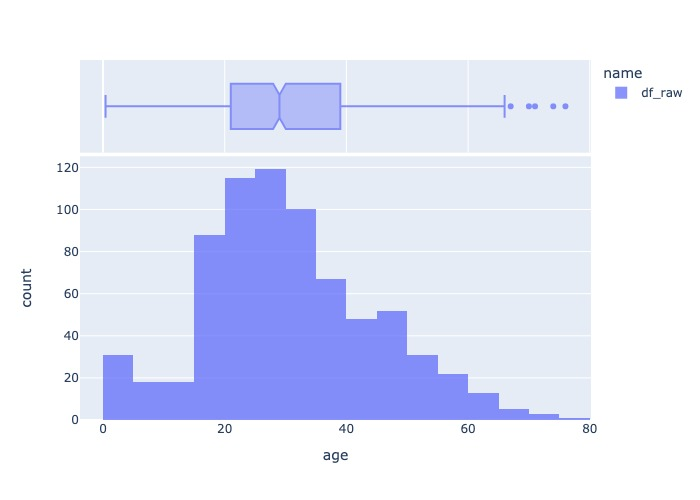

In [184]:
hist_boxsplot('age', X_train)

### Z-score
- `Outlier` = {`x` | (`x`> `mean` + `3sdt`) or (`x`< `mean` - `3std`) }

### Interquartile Range
- IQR = the 75th percentile - the 25th percentile
- outliers out of upper/lower boundary
    - `Upper boundary` = `75th quantile` + (`IQR` * 1.5)
    - `Lower boundary` = `25th quantile` - (`IQR` * 1.5)
- extreme case
    - `Upper boundary` = `75th quantile` + (`IQR` * 3)
    - `Lower boundary` = `25th quantile` - (`IQR` * 3)

### Local Outlier Factor (LOF)

**Terms**
- **`K-distance`** : của 1 điểm là khoảng cách từ điểm đó tới điểm thứ k gần nhất

- **`K-neighbors`** Nₖ(A): của 1 điểm A là tập hợp các điểm có khoảng cách nhỏ hơn hoặc bằng K-distance của A. (trong vùng K-neighbors có ít nhất K điểm). ||Nₖ(A)|| là số điểm trong K-neighbors.

- **`reachability density (RD)`** : khoảng cách của 1 điểm so với điểm đó, với k-distance của điểm đó

    $$RD(A,X) = max( K-distance(X), distance(A,X) )$$

- **`Local reachability density (LRD)`** :

    $$LRD_{k}(A)=\frac{1}{\sum_{X_j \in N_{k}(A)}\frac{\mathrm{RD}(A,X j)}{||N_{k}(A)||}}$$

    - thể hiện 1 điểm cách cụm gần nhất xa hay không, low LRD thể hiệm điểm đó càng cách xa cụm gần nhất.

- **`local outlier factor (LOF)`**: so sánh LRD trung bình của các điểm thuộc k-neighbors của điểm A với LRD(A)

    $$LOF_{k}(A)=\frac{\sum_{X j\,\,\in N_{k}(A)}\,LRD_{k}(X j)}{||N_{k}(A)||}\times\frac{1}{LRD_{k}(A)}$$

    - LOF <= 1 thường không phải là outlier, LOF lớn có thể là outliers.

    
**Advantages**
- Khá nhạy cảm với điểm nằm gần cụm có mật độ dày nhưng vẫn có thể track là outlier

**Disadvantages**
- Không có boundary inlier, nên không có method để predict dữ liệu mới liệu có phải outlier hay không ?
- Không áp dụng được khi có dữ liệu mới
- LOF là phương pháp xác định ngoại lai cho 1 cụm local nào đó thay vì global, lựa chọn K phụ thuộc vào người dùng. 

In [13]:
from sklearn.neighbors import LocalOutlierFactor

# identify outliers in the training dataset
lof = LocalOutlierFactor()
x_inliers_hat = lof.fit_predict(X_train)

# select all rows that are not outliers
mask = (x_inliers_hat != -1)
X_train_inliers, y_train_inliers = X_train.loc[mask, :], y_train.loc[mask]

# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)
print(X_train_inliers.shape, y_train_inliers.shape)

(731, 2) (731,)
(701, 2) (701,)


### Isolation Forest
- Sử dụng phân tách cây quyết định nhị phân để tách thành tối đa các leaf, với feature selection và threshold ngẫu nhiên. mức độ score được do bởi độ sâu của lá so với root.

**Disadvantages:**
- Mô hình phụ thuộc vào hệ số `Contamination` là tỷ lệ outlier trong sample
- Mô hình có khả năng bị bias do phương pháp binary cut, ví dụ:
( khắc phụ bằng model `Extended Isolation Forest` - thay đổi intercept và slope ngẫu nhiên đường brand cut)

<img src = "_images/08outliers_out2.png">

**--> `Isolation Forest` tạo ra các vùng có khả năng không là outlier nhưng thực tế nếu có point tại đó thì là outlier**

<img src = "_images/08outliers_out3.png">


**So sánh `Isolation Forest` và biến thể**


In [14]:
# Vanilla Isolation Forest
from sklearn.ensemble import IsolationForest

# identify outliers in the training dataset
IF = IsolationForest(contamination = 0.1) # Contamination là tỷ lệ outlier
x_inliers_hat = IF.fit_predict(X_train)

# select all rows that are not outliers
mask = (x_inliers_hat != -1)
X_train_inliers, y_train_inliers = X_train.loc[mask, :], y_train.loc[mask]

# summarize the shape of the updated training dataset
print('before remove outliers:',X_train.shape, y_train.shape)
print('after remove outliers: ',X_train_inliers.shape, y_train_inliers.shape)

before remove outliers: (731, 2) (731,)
after remove outliers:  (658, 2) (658,)


/Users/khongdat/miniforge3/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [ ]:
# Extended Isolation Forest
import eif as iso

# change the ExtensionLevel (default = 0 at Vanilla IF), change to (n_dimensions - 1)
eif = iso.iForest(X_train.values, 
                  ntrees = 100, 
                  sample_size = 256, 
                  ExtensionLevel = X_train.shape[1] - 1)

anomaly_scores = eif.compute_paths(X_in = X_train.values)
anomaly_scores_sorted = np.argsort(anomaly_scores)
indices_with_preds = anomaly_scores_sorted[-int(np.ceil(anomalies_ratio * X_train.shape[0])):]
y_pred = np.zeros_like(y_train)
y_pred[indices_with_preds] = 1

### Elliptic Envelope
- Áp dụng cho dữ liệu phân bố ellip gaussian

**Procedure**

- lấy các subset từ samples với size cố định và chọn ra subset có covariance nhỏ nhất. 
- Tính parameter từ subsample được chọn và outlier là những point có khoảng cách lớn nhất với cụm sample.

In [15]:
from sklearn.covariance import EllipticEnvelope

# identify outliers in the training dataset
ee = EllipticEnvelope(contamination = 0.1) # Contamination là tỷ lệ outlier
x_inliers_hat = ee.fit_predict(X_train)

# select all rows that are not outliers
mask = (x_inliers_hat != -1)
X_train_inliers, y_train_inliers = X_train.loc[mask, :], y_train.loc[mask]

# summarize the shape of the updated training dataset
print('before remove outliers:',X_train.shape, y_train.shape)
print('after remove outliers: ',X_train_inliers.shape, y_train_inliers.shape)

before remove outliers: (731, 2) (731,)
after remove outliers:  (658, 2) (658,)


### One-Class SVM

- `One-class SVM` là 1 biến thể của `Standard-SVM`.
    - Với thuật toán **Standard-SVM**, sẽ tìm 1 **hyperplane** (siêu mặt phẳng) để phân tách 2 classes với margin lớn nhất có thể (cách đều 2 điểm `positive` và `negative` gần nhất)
    - Với **One-class SVM** sẽ tương tự, nhưng thay vào đó sẽ tìm 1 **hyperphere** (siêu cầu) đều bao gọn các điểm `normal` bên trong, các điểm bên ngoài **hypersphere** sẽ là `outliers`
    
- **Challenge**:
    - Requires fine-tuning of its hyperparameter `nu` to handle outliers and prevent overfitting

- `SGDOneClassSVM` : is An online linear version of the **One-Class SVM**. This implementation scales linearly with the number of samples and can be used with a kernel approximation to approximate the solution of a kernelized svm.OneClassSVM whose complexity is at best quadratic in the number of samples, uses a Gaussian kernel by default

In [16]:
from sklearn.svm import OneClassSVM

oc = OneClassSVM(nu=0.01) # nu: % outliers in sample
x_inliers_hat = oc.fit_predict(X_train)

# select all rows that are not outliers
mask = x_inliers_hat != -1
X_train_inliers, y_train_inliers = X_train.loc[mask, :], y_train.loc[mask]

# summarize the shape of the updated training dataset
print('before remove outliers:',X_train.shape, y_train.shape)
print('after remove outliers: ',X_train_inliers.shape, y_train_inliers.shape)

before remove outliers: (731, 2) (731,)
after remove outliers:  (726, 2) (726,)


## Outlier handling
- `Trimming`: remove the outliers from our dataset
    - Pros: Quick
    - Cons: Outliers could be contained useful information in other variables, and may be remove a big chunk of dataset
- `Treat`: outliers would be assign as missing data, and proceed with any `missing data imputation technique`
    - Pros: does not remove data
    - Cons: distorts the distributions of the variables and relationship among variables
- `Discrestisation`: outliers are placed in border bins together with higher or lower values of the distribution
- `Censoring` (winsorization/capping/top-bottom coding): capping the variable distribution at a max and / or minimum value, than any value out of cap range would be replace by cap value.
    - Pros: does not remove data
    - Cons: distorts the distributions of the variables and relationship among variables

In [211]:
def outlier_action(var, df, action_method = 'trim', assign_params = ('iqr',1.5)):
    """
    action_method is in ('trim', 'cap', 'treat')
        - trim: drop outliers obs
        - treat: assign outliers value into missing (np.nan)
        - cap: assign outliers by the nearest boundary of inliers range
    assign_params are method's name and its parameter to assign inlier in `assign_inliers` function:
    """
    df_c = df.copy()
    mask, interval = assign_inliers(df_c[var], method = assign_params[0], params = assign_params[1:], retbin_inlier = True)
    if action_method == 'trim':
        return df_c[mask]
    elif action_method == 'treat':
        df_c.loc[~mask, var] = np.nan
        return df_c
    elif action_method == 'cap':
        df_c.loc[sr_c < interval[0], var] = interval[0]
        df_c.loc[sr_c > interval[1], var] = interval[1]
        return df_c

### Trimming

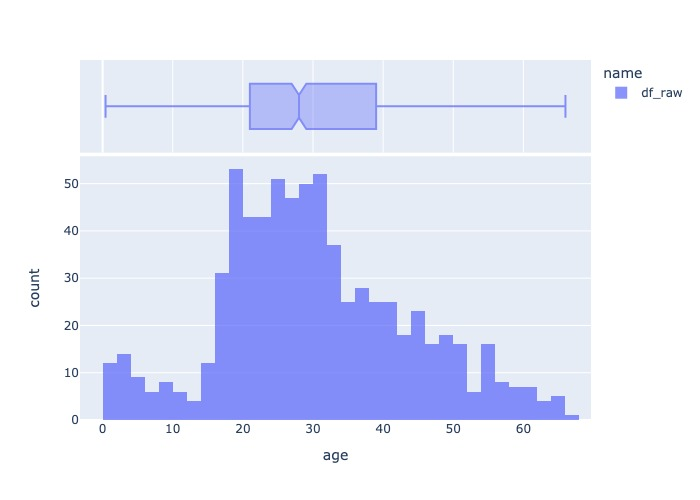

In [212]:
X_train_trim = outlier_action('age', X_train, 'trim')
hist_boxsplot('age', X_train_trim)

In [219]:
from feature_engine.outliers import OutlierTrimmer

# set up the capper
capper = OutlierTrimmer(capping_method='iqr', tail='right', fold=1.5, variables=['age', 'fare'])

# fit the capper
capper.fit(X_train)

# transform the data
train_t= capper.transform(X_train)
test_t= capper.transform(X_test)

### Treat

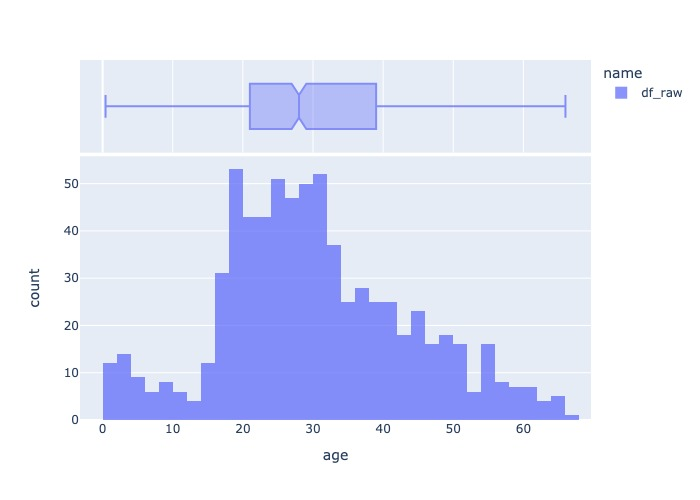

In [213]:
X_train_treat = outlier_action('age', X_train, 'treat')
hist_boxsplot('age', X_train_treat)

### Cap

In [214]:
# cap by iqr, gaussian, quantiles

from feature_engine.outliers import Winsorizer

cap = Winsorizer(
    capping_method = 'iqr', # gaussian, quantiles
    tail = 'both',
    fold = 1.5,
    add_indicators= False,
    variables = ['age'],
    missing_values= 'ignore',
)

cap.fit(X_train)

train_t = cap.transform(X_train)
test_t = cap.transform(X_test)

In [217]:
# cap by arbitracy value
from feature_engine.outliers import ArbitraryOutlierCapper

cap  = ArbitraryOutlierCapper(
    max_capping_dict={'age': 50, 'fare': 200},
    min_capping_dict={'age': 10, 'fare': 100}
        )

cap.fit(X_train)

train_t = cap.transform(X_train)
test_t = cap.transform(X_test)